### Import

In [17]:
from predict_ensemble_and_evaluate import predict_ensemble_and_evaluate
from predict_ensemble_and_evaluate import plot_roc_comparison

## Display function

In [18]:
#function for displaying ROC curves of multiple classifiers

import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import auc

def plot_roc_connected_points(results_list, results_original_roc, name="All Classifiers"):
    """
    Creates a plot showing the performance of all classifiers as points,
    and connects them with a line, sorted by FPR.

    Args:
        results_list: A list of dictionaries, where each dict contains 'fpr', 'tpr'.
    """
    if not results_list:
        print("No results to plot.")
        return

    # Convert results to a pandas DataFrame for easy sorting
    df = pd.DataFrame(results_list)
    
    # Sort the models by their False Positive Rate to create a left-to-right line
    df_sorted = df.sort_values(by=['fpr','tpr']).reset_index(drop=True)
    
    # --- Plotting ---
    plt.figure(figsize=(10, 10))
    
    # Plot all the individual model points as a scatter plot
    # This helps see the actual performance of each model
    plt.scatter(df_sorted['fpr'], df_sorted['tpr'], c='black', marker='o', 
                alpha=0.6, s=100, zorder=3) # zorder=3 puts dots on top

    # Plot the line connecting the points
    plt.plot(df_sorted['fpr'], df_sorted['tpr'], color='red', lw=1.5,
             alpha=0.8, label=f'{name} (AUC = {auc(df_sorted["fpr"], df_sorted["tpr"]):.2f})')
    
    #plot the original ROC curve
    plt.plot(results_original_roc["fpr"], results_original_roc["tpr"], color='blue', 
             label=f'{results_original_roc["name"]} (AUC = {results_original_roc["auc"]:.2f})')

    # Plot the "no-skill" line for reference
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate (FPR)')
    plt.ylabel('True Positive Rate (TPR)')
    plt.title('Performance Path of All Trained Classifiers')
    plt.legend(loc="lower right")
    plt.grid(True)
    plt.show()

## Best ROC envelope

In [19]:
import numpy as np
from sklearn.metrics import roc_curve

def get_best_roc_envelope(results_list, results_original_roc=None):
    """
    Constructs the upper envelope of multiple ROC curves to find the best
    possible operating points from a collection of classifiers.

    This function is guaranteed to produce a list of points that starts at
    (FPR=0, TPR=0) and ends at (FPR=1, TPR=1), making it suitable for direct
    plotting and AUC calculation.

    Args:
        results_list (list): A list of dictionaries. Each dictionary must
                             contain a 'model' name and the full ROC results
                             under the 'full_roc' key.
        results_original_roc (dict, optional): A dictionary containing the
                                               ROC results of a baseline model,
                                               which will also be included in
                                               the comparison. Defaults to None.

    Returns:
        list: A sorted list of dictionaries representing the optimal ROC
              envelope. Each dictionary includes 'model', 'fpr', 'tpr',
              and 'threshold'.
    """
    all_points = []

    # Step 1: Gather all ROC points from all provided models
    all_results = results_list[:]
    if results_original_roc:
        all_results.append({
            'model': 'original_baseline',
            'full_roc': results_original_roc
        })

    for result in all_results:
        model_name = result.get('model', 'Unknown Model')
        roc = result.get('full_roc')
        if not roc: continue

        fprs = roc.get('fpr', [])
        tprs = roc.get('tpr', [])
        thresholds = roc.get('thresholds', [])

        for i in range(len(fprs)):
            threshold = thresholds[i] if i < len(thresholds) else thresholds[-1]
            all_points.append({
                'model': model_name, 'fpr': fprs[i],
                'tpr': tprs[i], 'threshold': threshold
            })

    # Handle case with no data by returning a default diagonal line
    if not all_points:
        return [
            {'model': 'start', 'fpr': 0.0, 'tpr': 0.0, 'threshold': np.inf},
            {'model': 'end', 'fpr': 1.0, 'tpr': 1.0, 'threshold': 0.0}
        ]

    # Step 2: Sort all points by FPR (asc), then by TPR (desc)
    all_points.sort(key=lambda p: (p['fpr'], -p['tpr']))

    # Step 3: Build the core ROC envelope
    best_roc_envelope = []
    max_tpr_so_far = -1.0
    for point in all_points:
        # Add a point only if it has a strictly higher TPR
        if point['tpr'] > max_tpr_so_far:
            # To prevent adding multiple points at the same FPR, check if the last point
            # has the same FPR and replace it if so (since this one has a higher TPR)
            if best_roc_envelope and best_roc_envelope[-1]['fpr'] == point['fpr']:
                best_roc_envelope[-1] = point
            else:
                best_roc_envelope.append(point)
            max_tpr_so_far = point['tpr']
    
    # Step 4: Manually add extremities if they are missing
    
    # Ensure the curve starts at (0, 0)
    if not best_roc_envelope or best_roc_envelope[0]['fpr'] > 0.0:
        best_roc_envelope.insert(0, {
            'model': 'start', 'fpr': 0.0, 'tpr': 0.0, 'threshold': np.inf
        })

    # Ensure the curve ends at (1, 1)
    if best_roc_envelope[-1]['fpr'] < 1.0 or best_roc_envelope[-1]['tpr'] < 1.0:
        best_roc_envelope.append({
            'model': 'end', 'fpr': 1.0, 'tpr': 1.0, 'threshold': 0.0
        })

    return best_roc_envelope

## Data generation

In [20]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

def generate_data(dataset):
    if dataset == "data1":
        no_predictors = 2
        no_samples = 1600
        no_classes = 2
        #kerneltype = 'linear'  #comment out for polynomial kernel
        #kerneltype = 'poly'  #comment out for linear kernel



        n_samples_per_cluster = 400
        n_clusters = 4

        # Create the clusters deterministically
        np.random.seed(0) # for reproducibility

        X = np.zeros((n_samples_per_cluster * n_clusters, 2))
        y = np.zeros(n_samples_per_cluster * n_clusters)

        # Cluster centers in corners of a square
        centers = [[0, 0], [2, 0], [0, 2], [2, 2]]

        # Assign points to clusters deterministically
        for i in range(n_clusters):
            cluster_indices = slice(i * n_samples_per_cluster, (i + 1) * n_samples_per_cluster)
            X[cluster_indices] = centers[i] + np.random.normal(scale=0.5, size=(n_samples_per_cluster, 2))
            if i == 0 or i == 3:
                y[cluster_indices] = 0
            else:
                y[cluster_indices] = 1



        #Visualize
        plt.figure(figsize=(8,8))
        plt.scatter(X[:,0], X[:,1], c=y, cmap='viridis', s=50)
        plt.title('Four Clusters of Equal Size')
        plt.xlabel('Feature 1')
        plt.ylabel('Feature 2')
        plt.show()

        #add intercept to X
        #X = np.hstack((np.ones((X.shape[0], 1)), X))

        # # shuffle data
        # permutation = np.random.permutation(no_samples)
        # X = X[permutation]
        # y = y[permutation]


        #Split data into training and testing sets
        # Step 1: Split off the 1000 training samples. The rest (600) go into a temporary pool.
        # We can use absolute numbers for the size.
        X_train, X_test, y_train, y_test = train_test_split(
            X, y,
            train_size=1000,  # Specify exactly 1000 samples for training
            random_state=42,
            stratify=y        # Crucial for classification: keeps class proportions the same
        )

        

        train_data = np.concatenate((X_train, y_train.reshape(-1, 1)), axis=1)
        test_data = np.concatenate((X_test, y_test.reshape(-1, 1)), axis=1)

        val_data = test_data

        print(f"Training data shape: {X_train.shape}, {y_train.shape}")
        print(f"Test data shape: {X_test.shape}, {y_test.shape}")
    elif dataset == "data2":
        no_predictors = 2
        no_samples = 1600
        no_classes = 2
        #kerneltype = 'linear'  #comment out for polynomial kernel
        #kerneltype = 'poly'  #comment out for linear kernel



        n_samples_per_cluster = 400
        n_clusters = 4

        # Create the clusters deterministically
        np.random.seed(0) # for reproducibility

        X = np.zeros((n_samples_per_cluster * n_clusters, 2))
        y = np.zeros(n_samples_per_cluster * n_clusters)

        # Cluster centers in corners of a square
        centers = [[0, 0], [2, 0], [1, 2], [1, 2]]

        # Assign points to clusters deterministically
        for i in range(n_clusters):
            cluster_indices = slice(i * n_samples_per_cluster, (i + 1) * n_samples_per_cluster)
            X[cluster_indices] = centers[i] + np.random.normal(scale=0.5, size=(n_samples_per_cluster, 2))
            if i == 0 or i == 3:
                y[cluster_indices] = 0
            else:
                y[cluster_indices] = 1



        #Visualize
        plt.figure(figsize=(8,8))
        plt.scatter(X[:,0], X[:,1], c=y, cmap='viridis', s=50)
        plt.title('Four Clusters of Equal Size')
        plt.xlabel('Feature 1')
        plt.ylabel('Feature 2')
        plt.show()

        #add intercept to X
        #X = np.hstack((np.ones((X.shape[0], 1)), X))

        # # shuffle data
        # permutation = np.random.permutation(no_samples)
        # X = X[permutation]
        # y = y[permutation]


        #Split data into training and testing sets
        # Step 1: Split off the 1000 training samples. The rest (600) go into a temporary pool.
        # We can use absolute numbers for the size.
        X_train, X_test, y_train, y_test = train_test_split(
            X, y,
            train_size=1000,  # Specify exactly 1000 samples for training
            random_state=42,
            stratify=y        # Crucial for classification: keeps class proportions the same
        )


        train_data = np.concatenate((X_train, y_train.reshape(-1, 1)), axis=1)
        test_data = np.concatenate((X_test, y_test.reshape(-1, 1)), axis=1)

        val_data = test_data

        print(f"Training data shape: {X_train.shape}, {y_train.shape}")
        print(f"Test data shape: {X_test.shape}, {y_test.shape}")

    elif dataset == "pneumoniaMNIST":
        import medmnist
        print(medmnist.__version__)
        # read in the PneumoniaMNIST dataset
        from medmnist import PneumoniaMNIST
        train_data = PneumoniaMNIST(split='train', download=True, size=224)
        test_data = PneumoniaMNIST(split='test', download=True, size=224)
        val_data = PneumoniaMNIST(split='val', download=True, size=224)
        # print the dataset info
        print(f"Number of training samples: {len(train_data)}")
        print(f"Number of test samples: {len(test_data)}")
        print(f"Number of validation samples: {len(val_data)}")

    elif dataset == "breast_cancer":
        from ucimlrepo import fetch_ucirepo
        from sklearn.compose import ColumnTransformer
        from sklearn.pipeline import Pipeline
        from sklearn.impute import SimpleImputer
        from sklearn.preprocessing import LabelEncoder, StandardScaler, OneHotEncoder
        from sklearn.model_selection import train_test_split

        # Fetch and print columns for the dataset your code is using

        # 1. Fetch data for Breast Cancer (ID 15)
        bc = fetch_ucirepo(id=14)
        X_df, y_df = bc.data.features, bc.data.targets

        # 2. Replace '?' with a standard missing value format
        X_df = X_df.replace('?', np.nan)

        # 3. Encode the target variable
        y = LabelEncoder().fit_transform(y_df.to_numpy().ravel())

        # 4. Define column lists using the correct names for this dataset
        categorical_features = ['age', 'menopause', 'tumor-size', 'inv-nodes', 'node-caps', 'breast', 'breast-quad', 'irradiat']
        numeric_features = ['deg-malig']

        # 5. Create preprocessing pipelines
        numeric_pipeline = Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='median')),
            ('scaler', StandardScaler())
        ])
        categorical_pipeline = Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='most_frequent')),
            ('onehot', OneHotEncoder(handle_unknown='ignore'))
        ])

        # 6. Build the master preprocessor
        preprocessor = ColumnTransformer(
            transformers=[
                ('num', numeric_pipeline, numeric_features),
                ('cat', categorical_pipeline, categorical_features)
            ])

        # 7. Apply the transformations
        X_sparse = preprocessor.fit_transform(X_df)

        X = X_sparse.toarray()

        # --- CRITICAL DEBUGGING STEP ---
        print(f"Shape of X after preprocessing: {X.shape}")
        # This MUST print a shape like (286, 46). If it prints (286, 0), the preprocessor failed.
        # -----------------------------

        # 8. Split the data
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, train_size=0.7, random_state=42, stratify=y
        )

        print(f"Training data shape: {X_train.shape}, {y_train.shape}")
        print(f"Test data shape: {X_test.shape}, {y_test.shape}")

        y_train = y_train.reshape(-1, 1) if len(y_train.shape) == 1 else y_train
        y_test = y_test.reshape(-1, 1) if len(y_test.shape) == 1 else y_test


        # 9. Concatenate the data
        train_data = np.concatenate((X_train, y_train), axis=1)
        test_data = np.concatenate((X_test, y_test), axis=1)
        val_data = test_data  # For simplicity, using test data as validation data

        print(f"Shape of training data: {train_data.shape}")
        print(f"Shape of test data: {test_data.shape}")

        print("\nData successfully processed and concatenated.")
        print(f"Shape of final training data: {train_data.shape}")


    return train_data, test_data, val_data


## Calculate Statistics function

In [21]:
import numpy as np
from sklearn.metrics import confusion_matrix

def get_fpr_tpr(clf_model, X_test, y_test, threshold=0.5):
    """
    Calculates the False Positive Rate (FPR) and True Positive Rate (TPR) at a given threshold.

    Args:
        X_test: The test features.
        y_test: The true test labels (0 or 1).
        threshold: The probability threshold.

    Returns:
        A dictionary containing the FPR and TPR. Returns None if there's an error.
    """
    try:
        y_prob = clf_model.predict_proba(X_test)[:, 1]
        y_pred = (y_prob >= threshold).astype(int)

        tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()

        fpr = fp / (fp + tn) if (fp + tn) > 0 else 0  #Avoid division by zero
        tpr = tp / (tp + fn) if (tp + fn) > 0 else 0 #Avoid division by zero
        precision = tp / (tp + fp) if (tp + fp) > 0 else 0
        recall = tp / (tp + fn) if (tp + fn) > 0 else 0
        f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
        accuracy = (tp + tn) / (tp + tn + fp + fn)
        misclassification_rate = 1 - accuracy

        return {"fpr": fpr, "tpr": tpr, "precision": precision, "recall": recall, "f1": f1, "accuracy": accuracy, "misclassification_rate": misclassification_rate}

    except ValueError as e:
        print(f"Error calculating FPR and TPR: {e}")
        return None





In [22]:
# Define constants
BATCH_SIZE = 64
LEARNING_RATE = 0.001
IMAGE_SIZE = 224
NUM_CLASSES = 1
NUM_CHANNELS = 1
NUM_EPOCHS = 1
NUM_WORKERS = 4
K_FOLDS = 4

## Data1: Logistic regression

In [23]:
from sklearn.model_selection import KFold
import torch
import torch.utils.data as data

train_data, test_data, val_data = generate_data("breast_cancer")  # Change to "data1", "data2", "pneumoniaMNIST" or "ionosphere" as needed


train_data_tensor = data.TensorDataset(torch.tensor(train_data[:, :-1], dtype=torch.float32),
                                        torch.tensor(train_data[:, -1], dtype=torch.float32))
train_loader = data.DataLoader(train_data_tensor, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS) #over-write later for k-fold cross-validation
test_data_tensor = data.TensorDataset(torch.tensor(test_data[:, :-1], dtype=torch.float32),
                                       torch.tensor(test_data[:, -1], dtype=torch.float32))
test_loader = data.DataLoader(test_data_tensor, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)

# initialize fold
kfold = KFold(n_splits=K_FOLDS, shuffle=True, random_state=42)


Shape of X after preprocessing: (286, 39)
Training data shape: (200, 39), (200,)
Test data shape: (86, 39), (86,)
Shape of training data: (200, 40)
Shape of test data: (86, 40)

Data successfully processed and concatenated.
Shape of final training data: (200, 40)


### Regular training

In [24]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, auc
# Logistic Regression
X_train = train_data[:, :-1]
y_train = train_data[:, -1]
X_test = test_data[:, :-1]
y_test = test_data[:, -1]
clf = LogisticRegression(fit_intercept=True)
clf.fit(X_train, y_train)

#calculate ROC results
fpr_roc, tpr_roc, threshold_roc = roc_curve(y_test, clf.predict_proba(X_test)[:, 1])
results_original_roc = {"fpr": fpr_roc, "tpr": tpr_roc, "thresholds": threshold_roc, "name": "Logistic Regression", "auc": auc(fpr_roc, tpr_roc), "model": clf}

## Weighted ROC curve

In [25]:


#store the weighted classifiers of all the folds
list_folds_weighted_clfs = []  # List to store classifiers from all folds
#store the best classfiers of all the folds 
list_folds_best_models = []  # List to store best models from all folds
# Weight the X_train and y_train for cost-sensitive learning
minority_class_weight = np.arange(0.001, 0.999, 0.01)
majority_class_weight = 1.0 - minority_class_weight
list_weighted_clfs = []


for fold, (train_ids, val_ids) in enumerate(kfold.split(train_data[:, :-1], train_data[:, -1])):
    list_weighted_clfs = [] # List to store the models trained at each stage
    best_clfs = [] # List to store the best models from each stage
    

    print(f"--- Starting Fold {fold + 1}/{K_FOLDS} ---")
    X_train_fold = train_data[train_ids][:, :-1]
    y_train_fold = train_data[train_ids][:, -1]
    X_test_fold = train_data[val_ids][:, :-1]
    y_test_fold = train_data[val_ids][:, -1]
    for w in minority_class_weight:
        class_weights = {0: 1 - w, 1: w}

        clf_weighted = LogisticRegression(fit_intercept=True, class_weight=class_weights)
        clf_weighted.fit(X_train_fold, y_train_fold)

        res = get_fpr_tpr(clf_weighted, X_test_fold, y_test_fold, threshold=0.5)

        array_of_all_fprs, array_of_all_tprs, threshold_vals = roc_curve(y_test_fold, clf_weighted.predict_proba(X_test_fold)[:, 1])

        current_result = {
            "model": clf_weighted,
            "fpr": res["fpr"],
            "tpr": res["tpr"],
            "threshold": 0.5,
            "full_roc": {"fpr": array_of_all_fprs, "tpr": array_of_all_tprs, "thresholds": threshold_vals},
        }
        list_weighted_clfs.append(current_result)
    best_clfs = get_best_roc_envelope(list_weighted_clfs, results_original_roc)
    list_folds_weighted_clfs.append(list_weighted_clfs)
    list_folds_best_models.append(best_clfs)

--- Starting Fold 1/4 ---
--- Starting Fold 2/4 ---
--- Starting Fold 3/4 ---
--- Starting Fold 4/4 ---


In [26]:
from predict_ensemble_and_evaluate import save_to_pickle, load_from_pickle
from predict_ensemble_and_evaluate import predict_ensemble_and_evaluate
from predict_ensemble_and_evaluate import plot_roc_comparison
from predict_ensemble_and_evaluate import make_curve_monotonic

# Save the data
save_to_pickle(list_folds_best_models, list_folds_weighted_clfs, results_original_roc, test_loader, filename='pickle/Logistic_BreastCancer_weighted.pkl')




Data saved to pickle/Logistic_BreastCancer_weighted.pkl


{'best_models': [[{'model': LogisticRegression(class_weight={0: np.float64(0.1090000000000001),
                                     1: np.float64(0.8909999999999999)}),
    'fpr': np.float64(0.0),
    'tpr': np.float64(0.38461538461538464),
    'threshold': np.float64(0.8781373864463851)},
   {'model': LogisticRegression(class_weight={0: np.float64(0.999), 1: np.float64(0.001)}),
    'fpr': np.float64(0.02702702702702703),
    'tpr': np.float64(0.46153846153846156),
    'threshold': np.float64(0.0005267184385905187)},
   {'model': LogisticRegression(class_weight={0: np.float64(0.999), 1: np.float64(0.001)}),
    'fpr': np.float64(0.05405405405405406),
    'tpr': np.float64(0.7692307692307693),
    'threshold': np.float64(0.0005162991156026154)},
   {'model': LogisticRegression(class_weight={0: np.float64(0.999), 1: np.float64(0.001)}),
    'fpr': np.float64(0.10810810810810811),
    'tpr': np.float64(0.8461538461538461),
    'threshold': np.float64(0.0005050918539825871)},
   {'model'

# Load pickle

In [27]:
from predict_ensemble_and_evaluate import save_to_pickle, load_from_pickle
from predict_ensemble_and_evaluate import predict_ensemble_and_evaluate
from predict_ensemble_and_evaluate import plot_roc_comparison
from predict_ensemble_and_evaluate import make_curve_monotonic

# Load the data
list_folds_best_models, list_folds_weighted_clfs, results_original_roc, test_loader = load_from_pickle(filename='pickle/Logistic_BreastCancer_weighted.pkl')

Data loaded successfully.


### Ensemble prediction using voting

In [28]:
import numpy as np

# --- Loop through all the FPR values to generate the ensemble ROC curve ---



results_tuple, prior_proba = predict_ensemble_and_evaluate(list_folds_best_models=list_folds_best_models,
    test_loader=test_loader)

ensemble_results_soft = results_tuple['soft_voting']
ensemble_results_hard = results_tuple['hard_voting']
misclassification_risk = results_tuple['misclassification_risk']






Creating a single ensemble from 66 models across all folds.
Extracting full dataset...
Getting predictions from all models...


## Calculate Neyman Pearson ROC curve

In [29]:
import os
from sklearn.datasets import make_classification
from sklearn.metrics import confusion_matrix, auc
import numpy as np
import torch
import torch.utils.data as data
from sklearn.model_selection import train_test_split
from nproc import npc
from sklearn.linear_model import LogisticRegression


# Define constants
BATCH_SIZE = 64
LEARNING_RATE = 0.001
IMAGE_SIZE = 224
NUM_CLASSES = 1
NUM_CHANNELS = 1
NUM_EPOCHS = 1
NUM_WORKERS = 4

train_data, test_data, val_data = generate_data("breast_cancer")  


train_data_tensor = data.TensorDataset(torch.tensor(train_data[:, :-1], dtype=torch.float32),
                                        torch.tensor(train_data[:, -1], dtype=torch.float32))
train_loader = data.DataLoader(train_data_tensor, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS) #over-write later for k-fold cross-validation
test_data_tensor = data.TensorDataset(torch.tensor(test_data[:, :-1], dtype=torch.float32),
                                       torch.tensor(test_data[:, -1], dtype=torch.float32))
test_loader = data.DataLoader(test_data_tensor, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)

X_train = train_data[:, :-1]
y_train = train_data[:, -1]
X_test = test_data[:, :-1]
y_test = test_data[:, -1]
print("Generating constrained ROC curve (Neyman-Pearson Simulation)...")

npc_instance = npc()

model = LogisticRegression(solver='liblinear', random_state=42)

result = npc_instance.npc(
    x=X_train, 
    y=y_train, 
    method="", # Leave blank to use the provided model
    model=model,
    rand_seed=42
)

# Extract the essential, one-time results
# The structure is result[fits][split_index][element_index]
fit_results = result[0][0]
final_model = fit_results[0] # The trained model
y_test_calib = fit_results[1]       # The labels from the calibration set
y_decision_values = fit_results[2]  # The scores from the single trained model
initial_sign = fit_results[4]       # The sign indicating score direction

print("Phase 1 Complete. Model trained and scores generated.")

# --- 3. Phase 2: Calculate All ROC Points Efficiently ---
print("\nPhase 2: Calculating cutoffs for all alphas without re-training...")

# Define the FPR constraints (alphas) we want to target
alphas = np.linspace(0, 1, 51)
roc_points = []

# Get the model's scores on the completely separate test set
y_test_scores = final_model.predict_proba(X_test)[:, 1]

# If the sign is True, it means lower scores are better for class 1.
# The npc_core function expects higher scores to be better, so we invert them once.
if initial_sign:
    y_decision_values = -y_decision_values
    y_test_scores = -y_test_scores

for i, alpha in enumerate(alphas):
    # Call ONLY the fast npc_core function
    core_result = npc_instance.npc_core(
        y_test=y_test_calib,
        y_decision_values=y_decision_values,
        alpha=alpha,
        delta=0.05,
        n_cores=1
    )
    
    if not core_result or core_result[6] == True: # core_result[6] is n_small flag
        print(f"Alpha {alpha:.2f} ({i+1}/{len(alphas)}): No valid cutoff found (sample size may be too small).")
        continue

    # Get the optimal cutoff for this specific alpha
    cutoff = core_result[0]

    # Manually apply the cutoff to the saved scores to get predictions
    # Note: We already handled the sign, so higher score is always better here.
    y_pred = (y_test_scores >= cutoff).astype(int)

    # Calculate TPR and FPR for this point
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    current_fpr = fp / (fp + tn) if (fp + tn) > 0 else 0
    current_tpr = tp / (tp + fn) if (tp + fn) > 0 else 0
    
    roc_points.append({'fpr': current_fpr, 'tpr': current_tpr})
    print(f"Alpha {alpha:.2f} ({i+1}/{len(alphas)}): FPR={current_fpr:.3f}, TPR={current_tpr:.3f}")

# --- 4. Process and Plot the Results ---
# Remove duplicate points
unique_points_dict = {(p['fpr'], p['tpr']): p for p in roc_points}
constrained_points = list(unique_points_dict.values())
constrained_points = sorted(constrained_points, key=lambda x: x['fpr'])

Shape of X after preprocessing: (286, 39)
Training data shape: (200, 39), (200,)
Test data shape: (86, 39), (86,)
Shape of training data: (200, 40)
Shape of test data: (86, 40)

Data successfully processed and concatenated.
Shape of final training data: (200, 40)
Generating constrained ROC curve (Neyman-Pearson Simulation)...
Phase 1 Complete. Model trained and scores generated.

Phase 2: Calculating cutoffs for all alphas without re-training...
Sample size is too small for the given alpha. Try a larger alpha.
Alpha 0.00 (1/51): No valid cutoff found (sample size may be too small).
Sample size is too small for the given alpha. Try a larger alpha.
Alpha 0.02 (2/51): No valid cutoff found (sample size may be too small).
Sample size is too small for the given alpha. Try a larger alpha.
Alpha 0.04 (3/51): No valid cutoff found (sample size may be too small).
Alpha 0.06 (4/51): FPR=0.033, TPR=0.077
Alpha 0.08 (5/51): FPR=0.050, TPR=0.115
Alpha 0.10 (6/51): FPR=0.050, TPR=0.192
Alpha 0.12 (7

In [30]:
from predict_ensemble_and_evaluate import save_to_pickle_constrained_roc

# Save the constrained ROC curve results
save_to_pickle_constrained_roc(constrained_points, filename='pickle/Logistic_Breast_Cancer_NP_roc_curve.pkl')

Constrained ROC curve points saved to pickle/Logistic_Breast_Cancer_NP_roc_curve.pkl


## Load NP curve pickle

In [31]:
from predict_ensemble_and_evaluate import load_from_pickle_constrained_roc

# Load the constrained ROC curve results
constrained_points = load_from_pickle_constrained_roc(filename='pickle/Logistic_Breast_Cancer_NP_roc_curve.pkl')

Constrained ROC curve points loaded from pickle/Logistic_Breast_Cancer_NP_roc_curve.pkl



--- Plotting all ROC curves for comparison ---


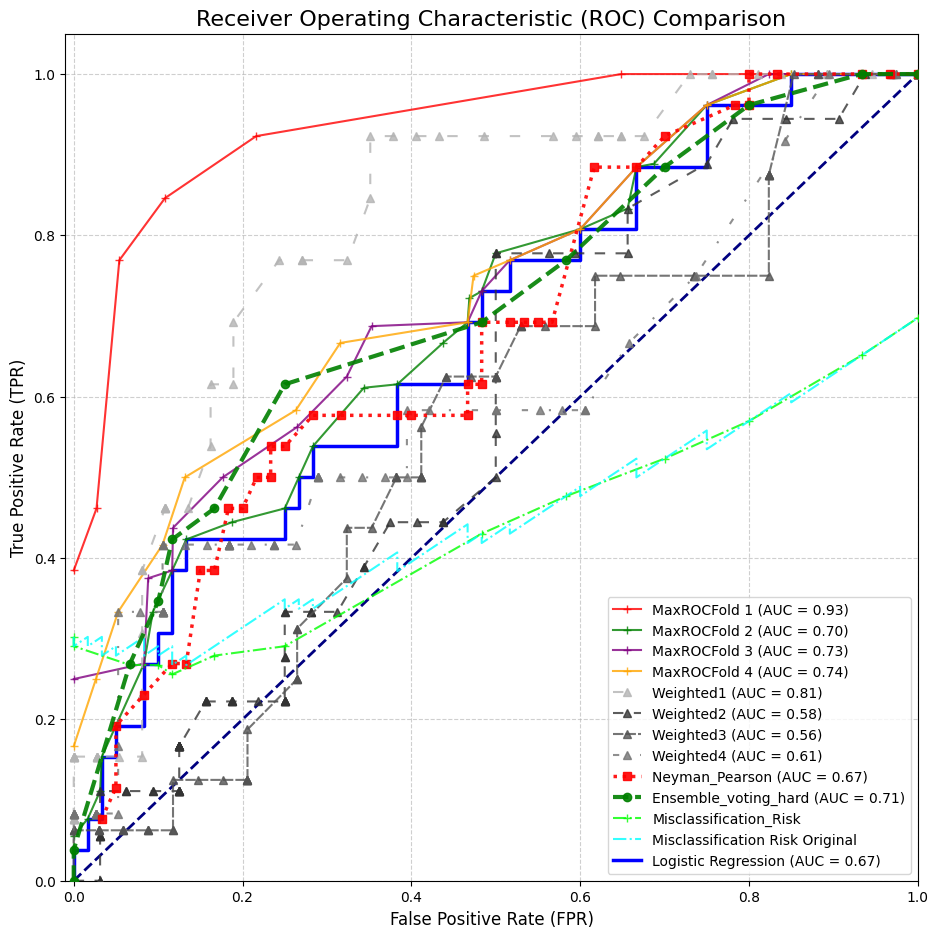

In [32]:

# plot the best classifiers of all folds
results_lists = []
results_lists.extend(list_folds_best_models)
results_lists.extend(list_folds_weighted_clfs)
results_lists.append(constrained_points)
results_lists.append(ensemble_results_hard)
results_lists.append(misclassification_risk)

# --- Plot the final comparison ---
print("\n--- Plotting all ROC curves for comparison ---")
plot_roc_comparison(
    results_lists=results_lists,
    names=["MaxROCFold 1", "MaxROCFold 2", "MaxROCFold 3", "MaxROCFold 4", "Weighted1", "Weighted2", "Weighted3", "Weighted4", "Neyman_Pearson", "Ensemble_voting_hard", "Misclassification_Risk"],
    results_original_roc=results_original_roc, plot_name="logistic_weighted_BreastCanser", prior_prob=prior_proba
)